In [24]:
# Imports

import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END, MessagesState, StateGraph, START

from IPython.display import Image, display

In [25]:
# conn = sqlite3.connect(":memory:", check_same_thread = False)
db_path = "./state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

model = ChatOpenAI(model="gpt-4o", temperature=0)

In [26]:
class State(MessagesState):
    summary: str

def call_model(state: State):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of the conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is a summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    """Return the next node to execute."""

    messages = state["messages"]

    if len(messages) > 6:
        return "summarize"

    return END

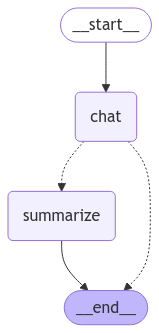

In [7]:
config = {"configurable": {"thread_id": "34"}}

workflow = StateGraph(State)
workflow.add_node("chat", call_model)
workflow.add_node("summarize", summarize_conversation)

workflow.add_edge(START, "chat")
workflow.add_conditional_edges("chat", should_continue)
workflow.add_edge("summarize", END)

graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def converse(message:str):
    input_message = HumanMessage(content=message)
    output = graph.invoke({"messages": [input_message]}, config)
    for m in output['messages'][-1:]:
        m.pretty_print()


# messages = [
#     "hi! I'm Angelo.",
#     "what was my name?",
#     "i like video games."
# ]

# for m in messages:
#     converse(m)



## Persisting state

In [23]:
graph_state = graph.get_state(config)
graph_state.values["messages"]

[HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='95e4681c-ed35-4755-b8df-7265daa93fa1'),
 AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 1307, 'total_tokens': 1317, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'stop', 'logprobs': None}, id='run-367efc04-68ce-4a2a-9bb8-84749423e9a6-0', usage_metadata={'input_tokens': 1307, 'output_tokens': 10, 'total_tokens': 1317, 'input_token_details': {'audio': 0, 'cache_read': 1152}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [11]:
messages = [
    "can you tell me more about grand strategy games?",
    "which company is the most popular for GSGs?",
    "how do i get a job at that company?"
]

for m in messages:
    converse(m)

================================== Ai Message ==================================

Certainly! Grand strategy games are a subgenre of strategy video games that focus on high-level strategic planning and management over large-scale environments, often spanning entire nations or even the world. These games typically involve complex decision-making and long-term planning, where players control various aspects of a civilization, country, or empire. Here are some key features of grand strategy games:

1. **Scale and Scope**: Grand strategy games often cover extensive time periods and large geographical areas. Players might manage an entire country or empire, dealing with political, economic, military, and diplomatic aspects.

2. **Complexity**: These games are known for their depth and complexity. Players must consider numerous factors, such as resource management, technological development, and international relations.

3. **Historical or Fictional Settings**: Many grand strategy games are s

In [21]:
converse("hello")

================================== Ai Message ==================================

Hello! How can I assist you today?
